In [1]:
ls drive/'My Drive'

 2_5332639447777280852.odg  'TSURU DOCS'/
'Colab Notebooks'/          'Untitled spreadsheet.gsheet'
 Documents/                  WHs/
 Drones/                     Визитки/
 knowledge/                 'ВР тех'/
 media.io_IROS2019.mp4      'Генеологическое древо.gsheet'
'One-ton drone project'/    'Копия segnet_clear (1).pt'
 Samsung/                   'Мега Сканирование помещений изнутри'/
 segnet1.pt                 'Проект Димы при поступлении.mp4'
 segnet_clear.pt


In [2]:
ls

BBBC018_v1_images-fixed/  checkpoint.pth  data.zip  meta.json  ptsemseg.zip
BBBC018_v1_outlines/      dataset/        drive/    ptsemseg/  sample_data/


In [3]:
from google.colab import files
uploaded = files.upload()

Saving dataset_class.py to dataset_class.py
Saving segnet.py to segnet.py
Saving utils.py to utils.py


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torchvision
from torchvision import transforms
from tqdm import tqdm

import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

from segnet import *
from dataset_class import *
# from apply import *

In [0]:
dataset = MyDataset('dataset/img/', 'dataset/masks_machine/')

In [0]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [0]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=16)

In [0]:
dataset[0][1].type()

'torch.LongTensor'

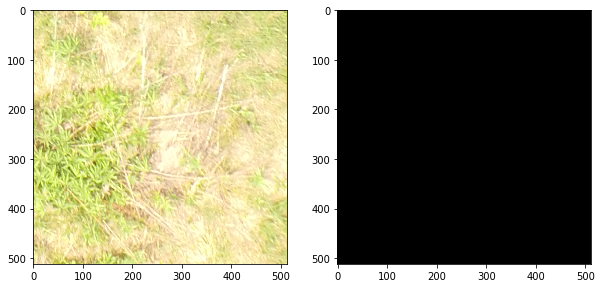

In [0]:
plt.figure(figsize=(10, 5))

sample = dataset[0]

plt.subplot(1, 2, 1)
plt.imshow(sample[0].permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(sample[1], 'gray')

In [0]:
sample[1]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [0]:
sample[1].sum()

tensor(254023)

In [0]:
dataset[10][1].sum()

tensor(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


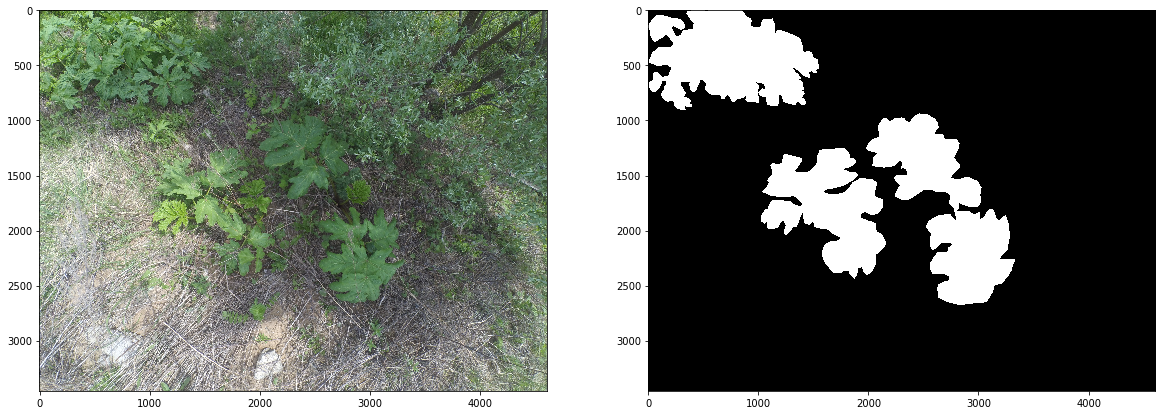

In [0]:
plt.figure(figsize=(20,16))
plt.subplot(1,2,1)
im = sp.misc.imread('NBST/img/0065.jpg')
plt.imshow(im)
plt.subplot(1,2,2)
mask = np.array(sp.misc.imread('NBST/masks_machine/0065.png'))[:,:,0]
plt.imshow(mask, 'gray')

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
model = segnet(n_classes=2, in_channels=3, is_unpooling=True).to(device)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

In [0]:
torch.cuda.device_count()

4

In [0]:
optim = torch.optim.Adam(model.parameters())
epochs = 100

In [0]:
loss_layer = nn.NLLLoss()

In [0]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [0]:
model.train(True)
for epoch in range(epochs):
    losses = []
    model.train(True)
    for i_train, (X, y) in tqdm(enumerate(train_loader)):
        X = X.to(device)  # [N, 3, H, W]
        y = y.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = loss_layer(F.log_softmax(prediction, dim=1), y)
        #loss = F.cross_entropy(prediction, y)
        losses.append(loss.cpu().data)

        optim.zero_grad()
        loss.backward()
        optim.step()
    
#     iou = []
#     model.train(False)
#     for i_batch, (X, y) in tqdm(enumerate(val_loader)):
#         X = X.to(device)  # [N, 3, H, W]
#         y = y.to(device)  # [N, H, W] with class indices (0, 1)
#         preds_class = apply_model_to_full_image(model, y, overlap=0.05, batch_size=32,device='cuda')
#         # prediction = model.forward(X)  # [N, 2, H, W]
#         # preds_class = torch.max(prediction, dim=1)[1]
#         iou.append(calc_iou(preds_class.cpu().numpy(), y.cpu().numpy()))
#    
#    print('epoch: {}, loss:{:.4f}, val iou:{:.4f}'.format(epoch + 1, np.mean(losses), np.mean(iou)))
    print('epoch: {}, loss:{:.4f}'.format(epoch + 1, np.mean(losses)))

14it [00:30,  1.34it/s]

epoch: 1, loss:0.6891



14it [00:19,  1.63it/s]

epoch: 2, loss:0.6610



14it [00:19,  1.60it/s]

epoch: 3, loss:0.6434



14it [00:18,  1.64it/s]

epoch: 4, loss:0.6293



14it [00:17,  1.63it/s]

epoch: 5, loss:0.6244



14it [00:18,  1.65it/s]

epoch: 6, loss:0.6172



14it [00:19,  1.61it/s]

epoch: 7, loss:0.6126



14it [00:19,  1.63it/s]

epoch: 8, loss:0.6076



14it [00:19,  1.59it/s]

epoch: 9, loss:0.5980



14it [00:18,  1.63it/s]

epoch: 10, loss:0.5982



14it [00:18,  1.64it/s]

epoch: 11, loss:0.5874



14it [00:18,  1.61it/s]

epoch: 12, loss:0.5778



14it [00:19,  1.60it/s]

epoch: 13, loss:0.5900



14it [00:19,  1.59it/s]

epoch: 14, loss:0.5749



14it [00:19,  1.60it/s]

epoch: 15, loss:0.5711



14it [00:19,  1.62it/s]

epoch: 16, loss:0.5628



14it [00:19,  1.63it/s]

epoch: 17, loss:0.5571



14it [00:19,  1.61it/s]

epoch: 18, loss:0.5472



14it [00:18,  1.61it/s]

epoch: 19, loss:0.5486



14it [00:19,  1.62it/s]

epoch: 20, loss:0.5379



14it [00:19,  1.61it/s]

epoch: 21, loss:0.5476



14it [00:18,  1.59it/s]

epoch: 22, loss:0.5319



14it [00:18,  1.62it/s]

epoch: 23, loss:0.5388



14it [00:19,  1.59it/s]

epoch: 24, loss:0.5202



14it [00:18,  1.60it/s]

epoch: 25, loss:0.5231



14it [00:19,  1.60it/s]

epoch: 26, loss:0.5282



14it [00:19,  1.61it/s]

epoch: 27, loss:0.5147



14it [00:19,  1.61it/s]

epoch: 28, loss:0.5212



14it [00:19,  1.56it/s]

epoch: 29, loss:0.5093



14it [00:19,  1.59it/s]

epoch: 30, loss:0.5014



14it [00:19,  1.60it/s]

epoch: 31, loss:0.4978



14it [00:19,  1.62it/s]

epoch: 32, loss:0.4886



14it [00:19,  1.61it/s]

epoch: 33, loss:0.4993



14it [00:19,  1.63it/s]

epoch: 34, loss:0.4917



14it [00:18,  1.63it/s]

epoch: 35, loss:0.4776



14it [00:19,  1.60it/s]

epoch: 36, loss:0.4881



14it [00:18,  1.61it/s]

epoch: 37, loss:0.4851



14it [00:19,  1.59it/s]

epoch: 38, loss:0.4720



14it [00:18,  1.62it/s]

epoch: 39, loss:0.4738



14it [00:19,  1.61it/s]

epoch: 40, loss:0.4538



14it [00:18,  1.61it/s]

epoch: 41, loss:0.4593



14it [00:19,  1.59it/s]

epoch: 42, loss:0.4504



14it [00:19,  1.55it/s]

epoch: 43, loss:0.4509



14it [00:18,  1.60it/s]

epoch: 44, loss:0.4512



14it [00:19,  1.59it/s]

epoch: 45, loss:0.4490



14it [00:18,  1.58it/s]

epoch: 46, loss:0.4539



14it [00:19,  1.61it/s]

epoch: 47, loss:0.4555



14it [00:18,  1.60it/s]

epoch: 48, loss:0.4406



14it [00:19,  1.59it/s]

epoch: 49, loss:0.4341



14it [00:19,  1.60it/s]

epoch: 50, loss:0.4315



14it [00:18,  1.63it/s]

epoch: 51, loss:0.4552



14it [00:18,  1.63it/s]

epoch: 52, loss:0.4329



14it [00:19,  1.63it/s]

epoch: 53, loss:0.4245



14it [00:18,  1.58it/s]

epoch: 54, loss:0.4440



14it [00:19,  1.54it/s]

epoch: 55, loss:0.4132



14it [00:19,  1.58it/s]

epoch: 56, loss:0.4109



14it [00:19,  1.59it/s]

epoch: 57, loss:0.4084



14it [00:19,  1.60it/s]

epoch: 58, loss:0.4086



14it [00:18,  1.60it/s]

epoch: 59, loss:0.3956



14it [00:19,  1.57it/s]

epoch: 60, loss:0.4030



14it [00:19,  1.59it/s]

epoch: 61, loss:0.4239



14it [00:19,  1.63it/s]

epoch: 62, loss:0.4311



14it [00:19,  1.62it/s]

epoch: 63, loss:0.4067



14it [00:18,  1.63it/s]

epoch: 64, loss:0.4020



14it [00:19,  1.59it/s]

epoch: 65, loss:0.3748



14it [00:19,  1.61it/s]

epoch: 66, loss:0.3967



14it [00:19,  1.61it/s]

epoch: 67, loss:0.4111



14it [00:19,  1.62it/s]

epoch: 68, loss:0.3895



14it [00:19,  1.61it/s]

epoch: 69, loss:0.3839



14it [00:18,  1.63it/s]

epoch: 70, loss:0.3850



14it [00:19,  1.56it/s]

epoch: 71, loss:0.3808



14it [00:19,  1.60it/s]

epoch: 72, loss:0.3746



14it [00:19,  1.56it/s]

epoch: 73, loss:0.3896



14it [00:18,  1.57it/s]

epoch: 74, loss:0.4077



14it [00:19,  1.62it/s]

epoch: 75, loss:0.4063



14it [00:18,  1.62it/s]

epoch: 76, loss:0.3735



14it [00:18,  1.63it/s]

epoch: 77, loss:0.3984



14it [00:19,  1.58it/s]

epoch: 78, loss:0.3778



14it [00:18,  1.63it/s]

epoch: 79, loss:0.3707



14it [00:19,  1.58it/s]

epoch: 80, loss:0.4221



14it [00:19,  1.59it/s]

epoch: 81, loss:0.3761



14it [00:19,  1.59it/s]

epoch: 82, loss:0.3747



14it [00:19,  1.56it/s]

epoch: 83, loss:0.3618



14it [00:18,  1.61it/s]

epoch: 84, loss:0.3696



14it [00:18,  1.62it/s]

epoch: 85, loss:0.3546



14it [00:20,  1.53it/s]

epoch: 86, loss:0.3580



14it [00:18,  1.61it/s]

epoch: 87, loss:0.3743



14it [00:19,  1.58it/s]

epoch: 88, loss:0.3426



14it [00:19,  1.60it/s]

epoch: 89, loss:0.3868



14it [00:19,  1.61it/s]

epoch: 90, loss:0.3554



14it [00:20,  1.59it/s]

epoch: 91, loss:0.3558



14it [00:19,  1.59it/s]

epoch: 92, loss:0.3830



14it [00:18,  1.58it/s]

epoch: 93, loss:0.3815



14it [00:19,  1.56it/s]

epoch: 94, loss:0.3259



14it [00:19,  1.61it/s]

epoch: 95, loss:0.3651



14it [00:19,  1.59it/s]

epoch: 96, loss:0.3468



14it [00:19,  1.59it/s]

epoch: 97, loss:0.3421



14it [00:19,  1.62it/s]

epoch: 98, loss:0.3311



14it [00:18,  1.57it/s]

epoch: 99, loss:0.3686



14it [00:19,  1.57it/s]

epoch: 100, loss:0.3422


In [0]:
torch.save(model, 'segnet1.pt')

In [0]:
device1 = torch.device('cuda:0')

In [0]:
model = torch.load('drive/''My Drive''/segnet1.pt').module.to(device1)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attr

In [0]:
dataset.is_train = False

In [0]:
sample = dataset[54]

In [0]:
sample[0].shape

torch.Size([3, 2250, 4000])

In [0]:
print(torch.__version__)

1.1.0


In [0]:
prediction = model.forward(sample[0].view(1, 3, 2250, 4000).to(device1))
preds_class = torch.max(prediction, dim=1)[1]

AttributeError: ignored

In [0]:
import random
import torchvision
from torchvision import transforms
from os.path import join
from glob import glob
import re 
from PIL import Image
import torchvision.transforms.functional as TF
from tqdm import tqdm


def transform(image,mask):
    # Random horizontal flipping
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    # Random vertical flipping
    if random.random() > 0.5:
        image = TF.vflip(image)
        mask = TF.vflip(mask)
    image = TF.resize(image,(512,512))
    mask = TF.resize(mask,(512,512))
    
    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)*255.
    return image, mask.squeeze().long()


class MemoryDataset(torch.utils.data.dataset.Dataset):
    def __init__(self,dataset):
        self.data = [v for v in tqdm(dataset)]
    def __len__(self): return len(self.data)
    def __getitem__(self,item): return self.data[item]

class Augmentator(torch.utils.data.dataset.Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __len__(self): return len(self.dataset)    
    def __getitem__(self,item):
        return transform(*self.dataset[item])


    
    
class SegData(torch.utils.data.dataset.Dataset):
    '''
    DataLoader to load tuples (original_image,mask)
    '''
    def _pil_loader(self,path,img_mode='RGB'):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert(img_mode)
        
    def __init__(self,path_to_orig='dataset/img',path_to_mask='dataset/masks_machine',transform=None,mask_transform=None):
        self.transform = transform
        self.mask_transform = mask_transform
        orig_files = {int(re.search('\d{4}',f).group(0)):f for f in glob(join(path_to_orig,"*.jpg"))}
        masked_files = {int(re.search('\d{4}',f).group(0)):f for f in glob(join(path_to_mask,"*.png"))}
        assert orig_files.keys() == masked_files.keys()
        self.data = [(orig_files[key],masked_files[key]) for key in orig_files.keys()]
    
    
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,item):
        orig = self._pil_loader(self.data[item][0])
        mask = self._pil_loader(self.data[item][1],img_mode='L')
        #orig,mask = self.transforms(orig,mask)
        return (orig,mask)

In [0]:
data = Augmentator(SegData())

In [0]:
data[0][1]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

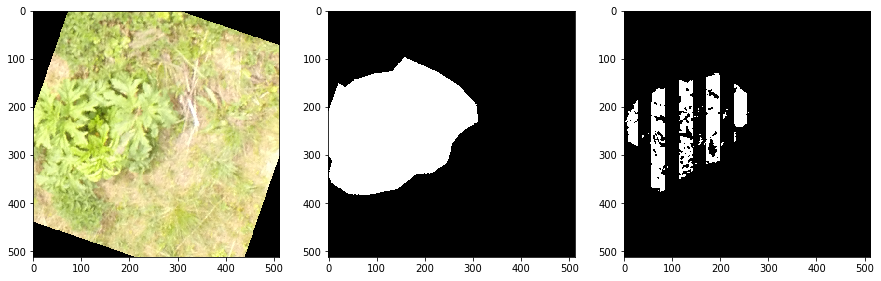

In [0]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(sample[0].permute(1, 2, 0))

plt.subplot(1, 3, 2)
plt.imshow(sample[1], 'gray')

plt.subplot(1, 3, 3)
plt.imshow(preds_class.squeeze().cpu().numpy(), cmap="gray")